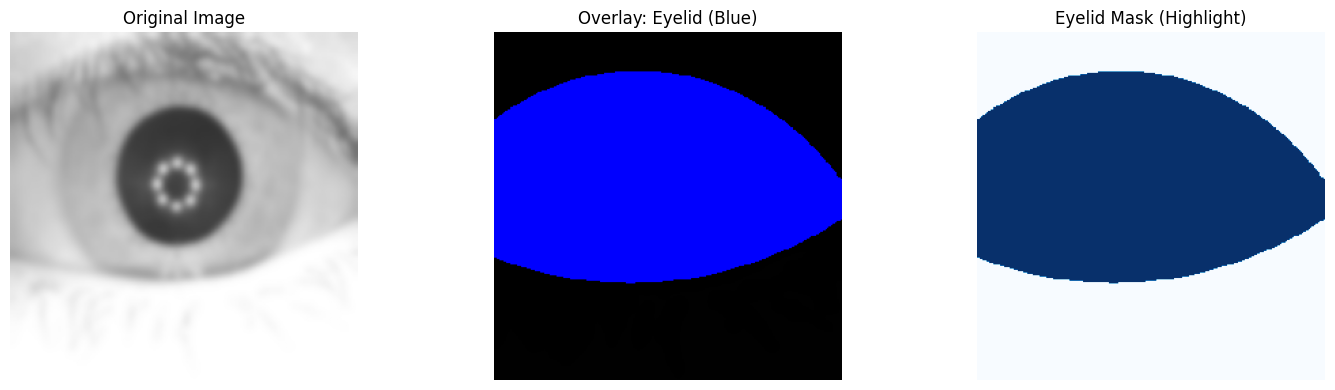

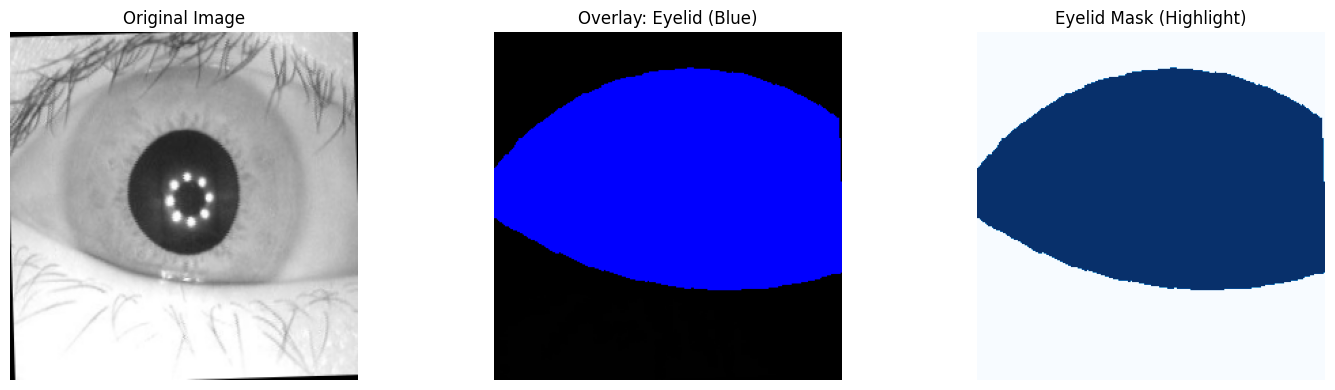

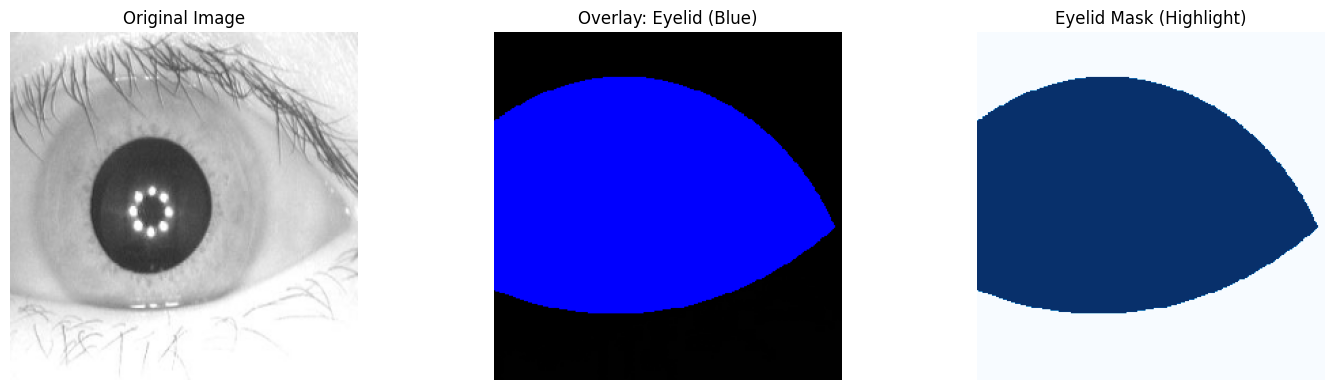

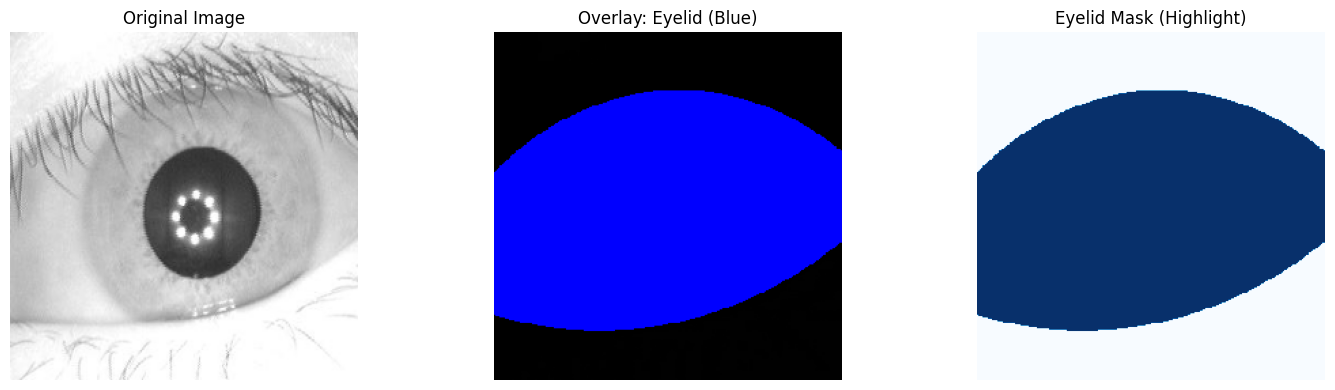

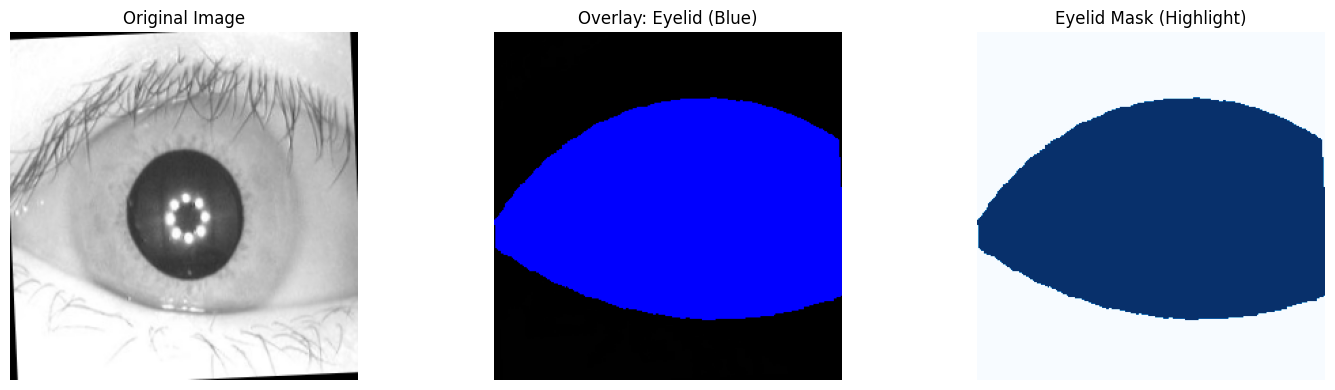

Train set size: 1141
Val set size: 286


In [1]:
import os
import cv2
import torch
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Dataset Class
class EyelidDataset(Dataset):
    def __init__(self, image_dir, eyelid_mat_dir, img_size=(256, 256), transform=None):
        jpgs = sorted(glob(os.path.join(image_dir, '*.jpg')))
        eyelid_mats = sorted(glob(os.path.join(eyelid_mat_dir, '*.mat')))

        jpg_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in jpgs}
        eyelid_dict = {os.path.splitext(os.path.basename(p))[0].replace('_eyelids_circles', ''): p for p in eyelid_mats}

        common_basenames = sorted(set(jpg_dict) & set(eyelid_dict))
        self.samples = [(jpg_dict[b], eyelid_dict[b]) for b in common_basenames]
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, eyelid_mat_path = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[:2]

        # Load eyelid information
        eyelid_data = scipy.io.loadmat(eyelid_mat_path)
        upper = eyelid_data['upper_eyelid'].flatten()
        lower = eyelid_data['lower_eyelid'].flatten()

        X, Y = np.meshgrid(np.arange(W), np.arange(H))
        eyelids_upper = ((X - upper[0])**2 + (Y - upper[1])**2) < upper[2]**2
        eyelids_lower = ((X - lower[0])**2 + (Y - lower[1])**2) < lower[2]**2
        eyelid_mask = (eyelids_upper & eyelids_lower).astype(np.uint8)

        # Only eyelid mask, no iris/pupil segmentation
        mask = np.expand_dims(eyelid_mask, axis=-1)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
        else:
            img = cv2.resize(img, self.img_size)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        # Use label mask: 0 = background, 1 = eyelid
        label_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        label_mask[mask[..., 0] > 0] = 1  # eyelid

        mask_tensor = torch.from_numpy(label_mask).float()  # Convert to float for BCEWithLogitsLoss

        return img_tensor, mask_tensor  # shape: [3, H, W], [H, W]


# Define transformations
train_transforms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.2),
])

val_transforms = A.Compose([
    A.Resize(256, 256)
])

# Instantiate the dataset (only for eyelid segmentation now)
dataset = EyelidDataset(
    image_dir='train_data/v3',
    eyelid_mat_dir='train_data/v3_eyelids',
    img_size=(256, 256),
    transform=train_transforms
)

# Visualize a few samples with highlighted eyelid region
for i in range(5):
    img, mask = dataset[i]  # shape: (3, H, W)
    img_np = img.permute(1, 2, 0).numpy()
    label_mask = mask.numpy()  # shape: (H, W)

    eyelid_mask = (label_mask == 1).astype(np.uint8)  # Only eyelid

    # Overlay: Draw eyelid first
    overlay = img_np.copy()

    # Draw Eyelid Mask in Blue
    overlay[eyelid_mask > 0] = [0, 0, 255]  # Blue for eyelid

    # Visualize
    plt.figure(figsize=(15, 4))

    # Raw image
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    # Eyelid mask overlay
    plt.subplot(1, 3, 2)
    plt.imshow(overlay.astype(np.uint8))
    plt.title("Overlay: Eyelid (Blue)")
    plt.axis("off")

    # Eyelid mask only (highlighted)
    plt.subplot(1, 3, 3)
    plt.imshow(eyelid_mask * 255, cmap='Blues')
    plt.title("Eyelid Mask (Highlight)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Train/Val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)
val_dataset.dataset.transform = val_transforms

print("Train set size:", len(train_dataset))
print("Val set size:", len(val_dataset))

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)






In [2]:
import os
import cv2
import torch
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Define the UNet model
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):  # num_classes = 1 for binary segmentation
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)

In [4]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)  # 1 output class for binary segmentation

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 10  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(img)

        # Calculate loss
        loss = criterion(outputs.squeeze(1), mask.squeeze(1))

        # Backpropagate
        loss.backward()

        # Update the weights
        optimizer.step()

        running_loss += loss.item()

    # Print loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)

            # Forward pass
            outputs = model(img)

            # Calculate validation loss
            loss = criterion(outputs.squeeze(1), mask.squeeze(1))
            val_loss += loss.item()

    print(f"Validation Loss after Epoch {epoch+1}: {val_loss / len(val_loader)}")

# Save the model
torch.save(model.state_dict(), 'eyelid_only.pth')




Epoch [1/10], Loss: 0.16588675392257585
Validation Loss after Epoch 1: 0.11555050416953033
Epoch [2/10], Loss: 0.08335657701729894
Validation Loss after Epoch 2: 0.07561230524960491
Epoch [3/10], Loss: 0.07646975921584176
Validation Loss after Epoch 3: 0.06967448049949275
Epoch [4/10], Loss: 0.05553244398190425
Validation Loss after Epoch 4: 0.0610519340261817
Epoch [5/10], Loss: 0.05927764976045469
Validation Loss after Epoch 5: 0.05262162639862961
Epoch [6/10], Loss: 0.048917825092802514
Validation Loss after Epoch 6: 0.04555078689008951
Epoch [7/10], Loss: 0.049615070822980854
Validation Loss after Epoch 7: 0.04560159146785736
Epoch [8/10], Loss: 0.0517341775389818
Validation Loss after Epoch 8: 0.2729203758968247
Epoch [9/10], Loss: 0.043988880564595434
Validation Loss after Epoch 9: 0.04022921554537283
Epoch [10/10], Loss: 0.041088923772836065
Validation Loss after Epoch 10: 0.04089050957312187


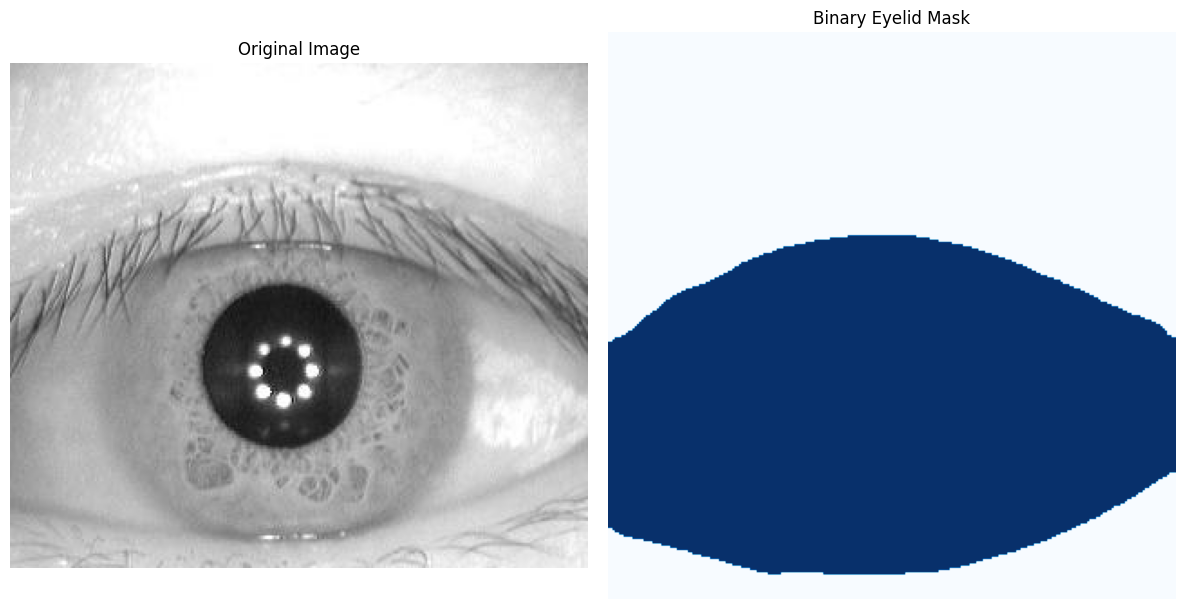

In [5]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load('eyelid_only.pth'))
model.eval()  # Set the model to evaluation mode

# Function to preprocess the input image
def preprocess_image(image_path, img_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, img_size)  # Resize image to match model input size

    # Normalize the image (similar to training)
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
    return img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Function to predict eyelid mask
def predict_eyelid_mask(image_path):
    img_tensor = preprocess_image(image_path)

    with torch.no_grad():  # Disable gradient calculation during inference
        output = model(img_tensor)  # Forward pass through the model
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        mask = (output.squeeze(0) > 0.5).cpu().numpy()  # Threshold to get binary mask

    return mask

# Function to visualize the original image and the binary mask side by side
def visualize_comparison(image_path, mask):
    # Load and preprocess the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Squeeze the extra dimension (if it exists) to get a 2D mask
    mask = mask.squeeze()  # This will change shape from (1, 256, 256) to (256, 256)

    # Create the plot for original image and binary mask side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Predicted binary mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='Blues')  # Display the binary mask using 'Blues' colormap
    plt.title("Binary Eyelid Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'images/S1218L02.jpg'  # Replace with your image path
mask = predict_eyelid_mask(image_path)
visualize_comparison(image_path, mask)  # Show original image next to the binary mask


Processing: train_data/v3/S1001L02.jpg


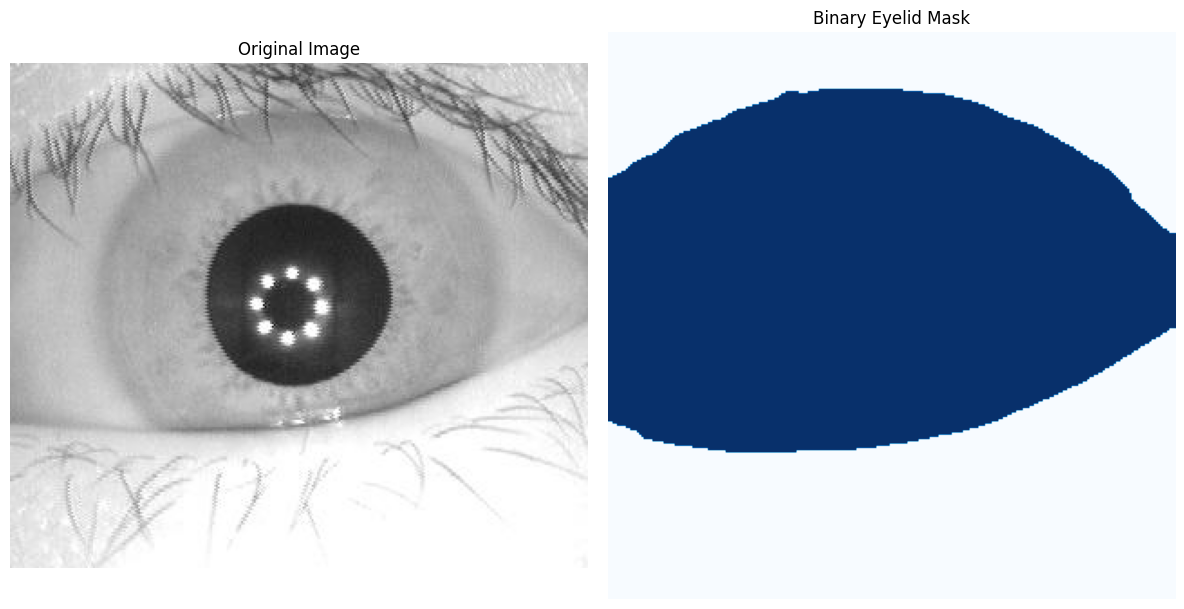

Processing: train_data/v3/S1001L04.jpg


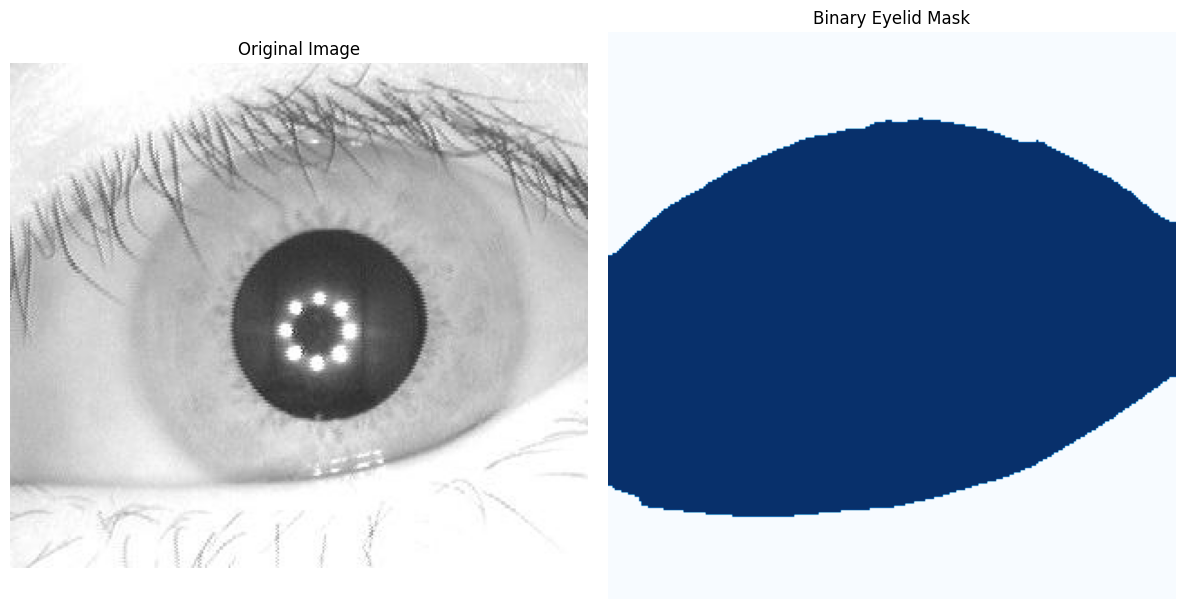

Processing: train_data/v3/S1001L03.jpg


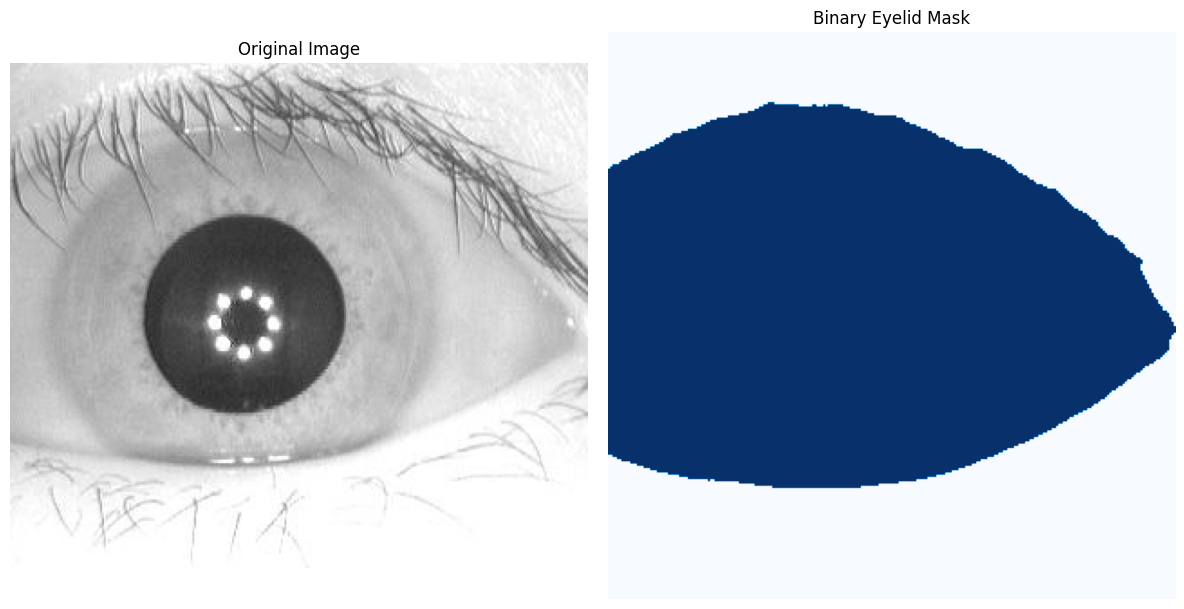

Processing: train_data/v3/S1001L06.jpg


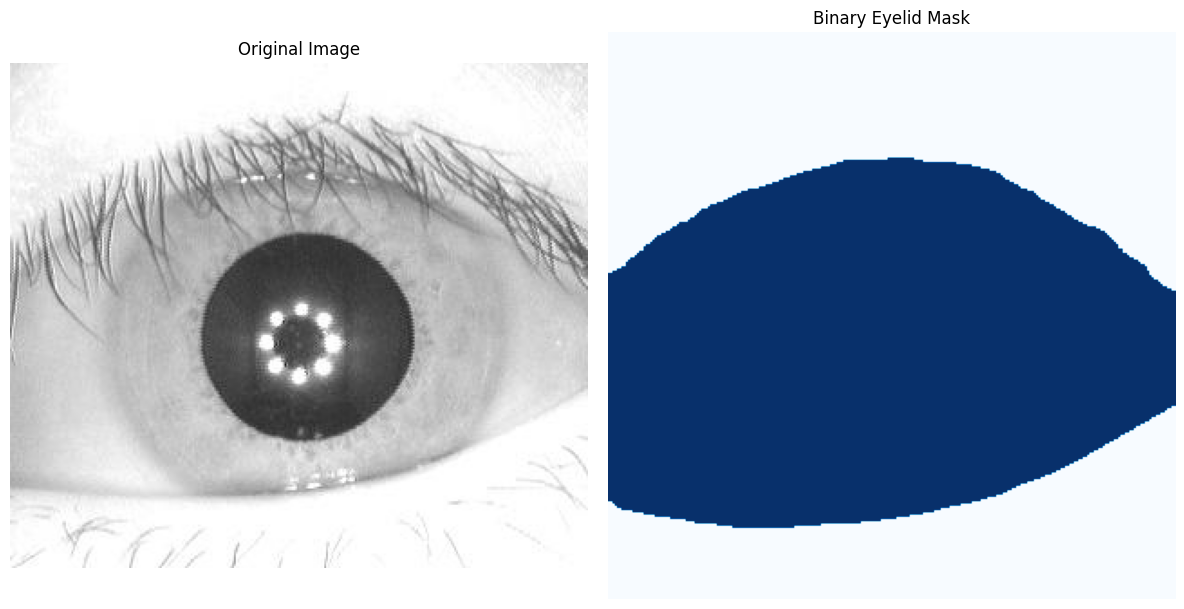

Processing: train_data/v3/S1001L05.jpg


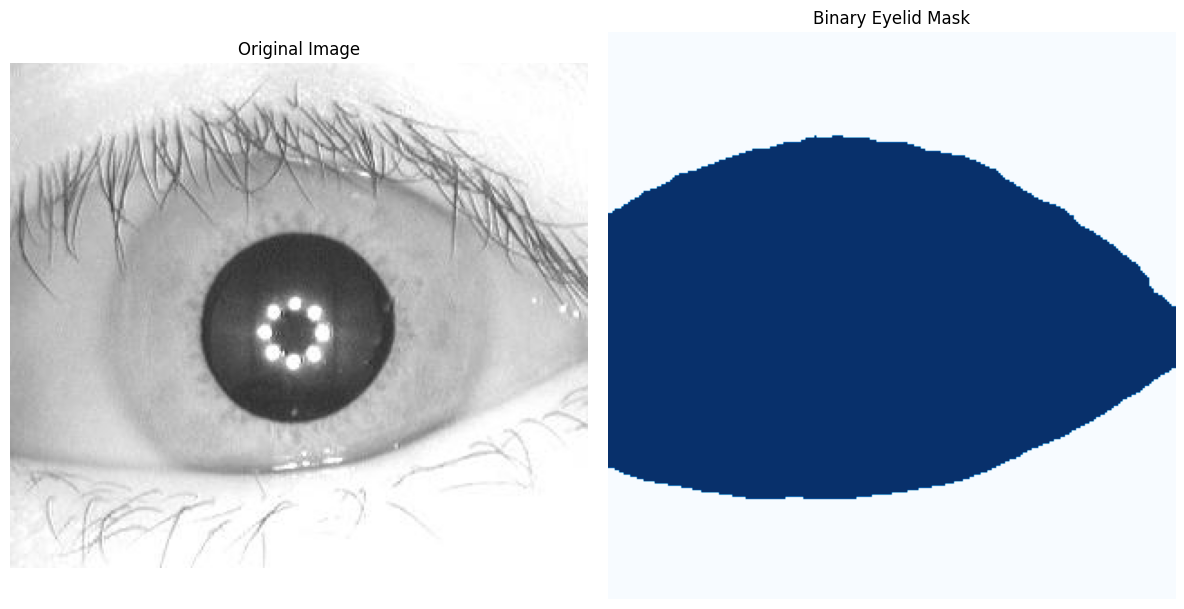